# Importing Libraires

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import re

import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, col, regexp_replace, split, substring_index
from pyspark.sql.functions import mean, stddev, corr
from pyspark.sql.functions import when,abs
from pyspark.sql.functions import isnull, count, isnan
from pyspark.sql.functions import min, max, mean, stddev
from pyspark.sql.functions import regexp_replace

In [88]:
# Spark Seesion
spark=SparkSession.builder.appName("Airbnb_Project").getOrCreate()
#spark = SparkSession.builder.config("spark.sql.legacy.timeParserPolicy","LEGACY").getOrCreate()

# Loading the Data

In [89]:
# Data Loading
df = spark.read.csv('/Airbnb_Open_Data.csv', header=True, inferSchema=True)

# Preview of the data with few columns and rows
selected_cols = df.columns[:25]
preview_df = df.select(selected_cols).limit(10)
preview_df.show()

+-------+--------------------+-----------+----------------------+---------+-------------------+------------------+--------+---------+-------------+------------+----------------+-------------------+---------------+-----------------+-------+-----------+--------------+-----------------+-----------+-----------------+------------------+------------------------------+----------------+--------------------+
|     id|                NAME|    host id|host_identity_verified|host name|neighbourhood group|     neighbourhood|     lat|     long|      country|country code|instant_bookable|cancellation_policy|      room type|Construction year|  price|service fee|minimum nights|number of reviews|last review|reviews per month|review rate number|calculated host listings count|availability 365|         house_rules|
+-------+--------------------+-----------+----------------------+---------+-------------------+------------------+--------+---------+-------------+------------+----------------+-----------------

In [90]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- host id: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host name: string (nullable = true)
 |-- neighbourhood group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- country: string (nullable = true)
 |-- country code: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- room type: string (nullable = true)
 |-- Construction year: string (nullable = true)
 |-- price: string (nullable = true)
 |-- service fee: string (nullable = true)
 |-- minimum nights: string (nullable = true)
 |-- number of reviews: string (nullable = true)
 |-- last review: string (nullable = true)
 |-- reviews per month: string (nullable = true)
 |-- review rate number: string (nullable = true)
 |-- calculated host listings count

In [91]:
#chekcing if min and max values are legit in last reviews
from pyspark.sql.functions import min, max

df.agg(min('last review'), max('last review')).show()

+----------------+----------------+
|min(last review)|max(last review)|
+----------------+----------------+
|               0|        9/9/2021|
+----------------+----------------+



# Data Cleaning

In [92]:
# Removing duplicates
df = df.dropDuplicates()

# Dropping unnecessary columns
df = df.drop('host name', 'license', 'country code', 'country', 'house_rules')

# Rename columns to remove spaces and make them more readable
df = df.withColumnRenamed("host id", "host_id") \
    .withColumnRenamed("neighbourhood group", "neighbourhood_group") \
    .withColumnRenamed("room type", "room_type") \
    .withColumnRenamed("number of reviews", "num_reviews") \
    .withColumnRenamed("reviews per month", "reviews_per_month") \
    .withColumnRenamed("review rate number", "review_rate_num") \
    .withColumnRenamed("calculated host listings count", "calculated_host_listings_count") \
    .withColumnRenamed("availability 365", "availability_365") \
    .withColumnRenamed("minimum nights", "minimum_nights") \
    .withColumnRenamed("service fee", "service_fee") \
    .withColumnRenamed("Construction year", "construction_year") \
    .withColumnRenamed("last review", "last_review")

In [93]:
from pyspark.sql.functions import regexp_replace

# Define list of punctuation signs to remove
signs = list('''()-[]{}:;'"\,<>./?@#$%^&*_~''')
escaped_signs = [re.escape(sign) for sign in signs]

# Remove the signs from the NAME column
for sign in escaped_signs:
    df = df.withColumn("NAME", regexp_replace("NAME", sign, ""))

selected_cols = df.columns[:7]
preview_df = df.select(selected_cols).limit(10)
preview_df.show()


+--------+--------------------+-----------+----------------------+-------------------+-------------------+--------+
|      id|                NAME|    host_id|host_identity_verified|neighbourhood_group|      neighbourhood|     lat|
+--------+--------------------+-----------+----------------------+-------------------+-------------------+--------+
| 8609821|   Marthas Apartment|87862035554|              verified|          Manhattan| Washington Heights| 40.8379|
|11103455|Just Right in Lov...| 2892335228|           unconfirmed|           Brooklyn|         Greenpoint| 40.7294|
|16423209|Lincoln Center St...|19110259416|           unconfirmed|          Manhattan|    Upper West Side|40.77562|
| 6531516|Private Bedroom i...|44757981395|           unconfirmed|          Manhattan|     Hell's Kitchen|40.75946|
|10448980|Manhattanvery clo...|57987722335|           unconfirmed|          Manhattan|Morningside Heights|40.81558|
|17032396|Greenpoint Sun Ga...|39608360710|           unconfirmed|      

In [94]:
# Remove numbers from the 'NAME' column
df = df.withColumn('NAME', regexp_replace('NAME', '\d+', ''))


In [95]:
# Count the missing values in each column
missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

# Display the missing values
missing_values.show(vertical=True, truncate=False)

-RECORD 0-------------------------------
 id                             | 0     
 NAME                           | 271   
 host_id                        | 378   
 host_identity_verified         | 670   
 neighbourhood_group            | 407   
 neighbourhood                  | 394   
 lat                            | 386   
 long                           | 388   
 instant_bookable               | 483   
 cancellation_policy            | 454   
 room_type                      | 378   
 construction_year              | 592   
 price                          | 625   
 service_fee                    | 653   
 minimum_nights                 | 778   
 num_reviews                    | 585   
 last_review                    | 16205 
 reviews_per_month              | 16167 
 review_rate_num                | 697   
 calculated_host_listings_count | 702   
 availability_365               | 995   



In [96]:
#checking if there are nay duplicates in neighborhood_group
df.groupBy('neighbourhood_group').agg(count('*').alias('count')).show()

+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|         Douglaston|    2|
|             Queens|13111|
|            Midtown|    5|
|     Hell's Kitchen|   14|
|  Greenwich Village|    4|
|       Clinton Hill|    3|
| Washington Heights|    8|
|   Ditmars Steinway|    9|
|           Longwood|    5|
|        Little Neck|    2|
|      Randall Manor|    3|
|            Norwood|    2|
|           Flushing|    7|
|             Carmen|    2|
|           verified|    3|
|      East Elmhurst|    3|
|    Upper East Side|    9|
|               NULL|  407|
|            Fordham|    1|
|         Bath Beach|    2|
+-------------------+-----+
only showing top 20 rows



In [97]:
from pyspark.sql.functions import min, max

df.agg(min('last_review'), max('last_review')).show()

+----------------+----------------+
|min(last_review)|max(last_review)|
+----------------+----------------+
|               0|        9/9/2021|
+----------------+----------------+



# Data Transformations

In [98]:
# Remove leading and trailing spaces in string columns
df = df.select([col(c).trim().alias(c) if df.schema[c].dataType == "string" else col(c) for c in df.columns])

# Replace $ and , in price column
df = df.withColumn("price", regexp_replace("price", "[$,]", ""))

# Replace $ and , in service fee column
df = df.withColumn("service_fee", regexp_replace("service_fee", "[$,]", ""))

# Converting relevant columns to appropriate data types
df = df.withColumn("lat", col("lat").cast("double"))
df = df.withColumn("long", col("long").cast("double"))
df = df.withColumn("price", col("price").cast("double"))
df = df.withColumn("service_fee", col("service_fee").cast("double"))
df = df.withColumn("minimum_nights", col("minimum_nights").cast("int"))
df = df.withColumn("num_reviews", col("num_reviews").cast("int"))
df = df.withColumn("reviews_per_month", col("reviews_per_month").cast("double"))
df = df.withColumn("review_rate_num", col("review_rate_num").cast("double"))
df = df.withColumn("availability_365", col("availability_365").cast("int"))
df = df.withColumn("construction_year", col("construction_year").cast("int"))

In [99]:
#showing unique neghbor hood

neighborhood_groups = df.select("neighbourhood_group").distinct().limit(25).collect()

# print the unique values to the console
for ng in neighborhood_groups:
    print(ng["neighbourhood_group"])

Douglaston
Queens
Nadia
Midtown
Jackson Heights
Hell's Kitchen
Greenwich Village
Clinton Hill
Washington Heights
Ditmars Steinway
Longwood
Briarwood
Little Neck
Randall Manor
Flushing
Carmen
verified
East Elmhurst
Upper East Side
Bath Beach
Canarsie
Evelyn
East Harlem
Astoria
East Village


In [100]:
from pyspark.sql.functions import abs

df = df.withColumn('minimum_nights', abs(df['minimum_nights']))

In [101]:
#showing uniqye room types
neighborhood_groups = df.select("room_type").distinct().limit(25).collect()

# print the unique values to the console
for ng in neighborhood_groups:
    print(ng["room_type"])

FALSE
flexible
2016
2012
2020
Shared room
2019
2017
2014
2013
2005
2018
2009
TRUE
Hotel room
2006
moderate
Entire home/apt
2004
2011
2022
2008
2007
Private room
2021


In [102]:
# Applying transformations

# df = df.withColumn('minimum_nights', abs(df['minimum_nights']))
# df = df.withColumn('availability_365', abs(df['availability_365']))

# Fill in missing values with a default value of 0
df = df.fillna({'service_fee': 0})
df = df.fillna({'reviews_per_month': 0})
df = df.fillna({'review_rate_num': 0})
df = df.fillna({'calculated_host_listings_count': 0})
df = df.fillna({'availability_365': 0})
df = df.fillna({'minimum_nights': 0})
#df = df.fillna({'cancellation_policy': 'unknown'})

# Print the distinct country names
distinct_cities = df.select(col("neighbourhood_group")).distinct()
distinct_cities.show()

# Correcting and replacing wrong names
df = df.withColumn("neighbourhood_group",
                   when(df["neighbourhood_group"] == "brookln", "Brooklyn")
                   .when(df["neighbourhood_group"] == "manhatan", "Manhattan")
                   .otherwise(df["neighbourhood_group"]))

# Print the distinct country names after correcting
distinct_cities1 = df.select(col("neighbourhood_group")).distinct()
distinct_cities1.show()

# Handle missing or null values
df = df.na.drop()

+-------------------+
|neighbourhood_group|
+-------------------+
|         Douglaston|
|             Queens|
|              Nadia|
|            Midtown|
|    Jackson Heights|
|     Hell's Kitchen|
|  Greenwich Village|
|       Clinton Hill|
| Washington Heights|
|   Ditmars Steinway|
|           Longwood|
|          Briarwood|
|        Little Neck|
|      Randall Manor|
|           Flushing|
|             Carmen|
|           verified|
|      East Elmhurst|
|    Upper East Side|
|         Bath Beach|
+-------------------+
only showing top 20 rows

+-------------------+
|neighbourhood_group|
+-------------------+
|         Douglaston|
|             Queens|
|              Nadia|
|            Midtown|
|    Jackson Heights|
|     Hell's Kitchen|
|  Greenwich Village|
|       Clinton Hill|
| Washington Heights|
|   Ditmars Steinway|
|           Longwood|
|          Briarwood|
|        Little Neck|
|      Randall Manor|
|           Flushing|
|             Carmen|
|           verified|
|     

# Data Profiling

In [103]:
# Compute basic statistics for the price column
price_stats = df.select(
    min("price").alias("min_price"),
    max("price").alias("max_price"),
    mean("price").alias("mean_price"),
    stddev("price").alias("stddev_price")
)
# Compute basic statistics for the service_fee column
service_fee_stats = df.select(
    min("service_fee").alias("min_service_fee"),
    max("service_fee").alias("max_service_fee"),
    mean("service_fee").alias("mean_service_fee"),
    stddev("service_fee").alias("stddev_service_fee")
)

# Show the results
price_stats.show()
service_fee_stats.show()

+---------+---------+-----------------+------------------+
|min_price|max_price|       mean_price|      stddev_price|
+---------+---------+-----------------+------------------+
|     50.0|   1200.0|626.0142138794353|331.65217328193256|
+---------+---------+-----------------+------------------+

+---------------+---------------+------------------+------------------+
|min_service_fee|max_service_fee|  mean_service_fee|stddev_service_fee|
+---------------+---------------+------------------+------------------+
|            0.0|          240.0|124.87262856671809| 66.53877283181525|
+---------------+---------------+------------------+------------------+



In [104]:
df = df.filter(df['minimum_nights'] != 0)


In [105]:
#cleaning for availability
df = df.withColumn("availability_365", when(df["availability_365"] > 365, 365).otherwise(df["availability_365"]))
df = df.withColumn("availability_365", when(df["availability_365"] < 0, abs(df['availability_365'])).otherwise(df["availability_365"]))
df_availability = df.select(col("availability_365")).distinct().orderBy("availability_365", ascending=False)
df_availability.show()

+----------------+
|availability_365|
+----------------+
|             365|
|             364|
|             363|
|             362|
|             361|
|             360|
|             359|
|             358|
|             357|
|             356|
|             355|
|             354|
|             353|
|             352|
|             351|
|             350|
|             349|
|             348|
|             347|
|             346|
+----------------+
only showing top 20 rows



In [106]:
# Previewing after cleaning the data

selected_cols = df.columns[:len(df.columns)]
preview_df = df.select(selected_cols).limit(10)
preview_df.show()

+--------+--------------------+-----------+----------------------+-------------------+-------------------+--------+---------+----------------+-------------------+---------------+-----------------+------+-----------+--------------+-----------+-----------+-----------------+---------------+------------------------------+----------------+
|      id|                NAME|    host_id|host_identity_verified|neighbourhood_group|      neighbourhood|     lat|     long|instant_bookable|cancellation_policy|      room_type|construction_year| price|service_fee|minimum_nights|num_reviews|last_review|reviews_per_month|review_rate_num|calculated_host_listings_count|availability_365|
+--------+--------------------+-----------+----------------------+-------------------+-------------------+--------+---------+----------------+-------------------+---------------+-----------------+------+-----------+--------------+-----------+-----------+-----------------+---------------+------------------------------+-------

In [107]:
pandas_df = df.toPandas()
df.head()

df1= df

In [108]:
print(df.dtypes)


[('id', 'string'), ('NAME', 'string'), ('host_id', 'string'), ('host_identity_verified', 'string'), ('neighbourhood_group', 'string'), ('neighbourhood', 'string'), ('lat', 'double'), ('long', 'double'), ('instant_bookable', 'string'), ('cancellation_policy', 'string'), ('room_type', 'string'), ('construction_year', 'int'), ('price', 'double'), ('service_fee', 'double'), ('minimum_nights', 'int'), ('num_reviews', 'int'), ('last_review', 'string'), ('reviews_per_month', 'double'), ('review_rate_num', 'double'), ('calculated_host_listings_count', 'double'), ('availability_365', 'int')]


In [109]:
df_pandas = df.toPandas()
df_pandas['neighbourhood_group'].value_counts()

Brooklyn         35137
Manhattan        35128
Queens           11221
Bronx             2287
Staten Island      830
Name: neighbourhood_group, dtype: int64

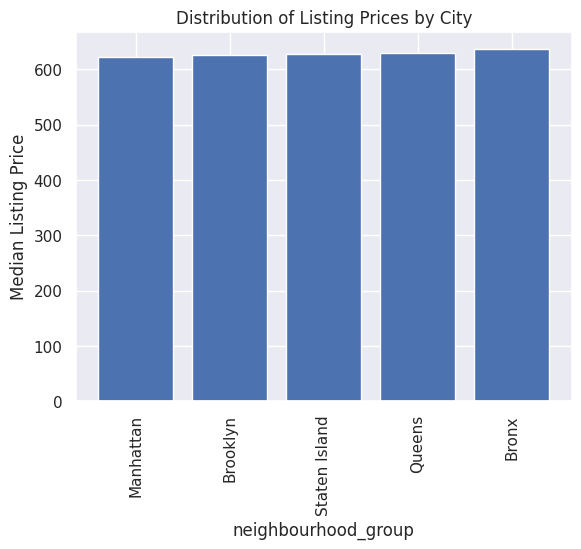

In [110]:
#Distribution of Listing Prices by City

# Group the data by city and calculate the median listing price for each city
median_prices_by_city = pandas_df.groupby("neighbourhood_group").median("price").sort_values("price")

# Create a bar chart showing the median listing price for each city
plt.bar(median_prices_by_city.index, median_prices_by_city["price"])
plt.xticks(rotation=90)
plt.xlabel("neighbourhood_group")
plt.ylabel("Median Listing Price")
plt.title("Distribution of Listing Prices by City")
plt.show()

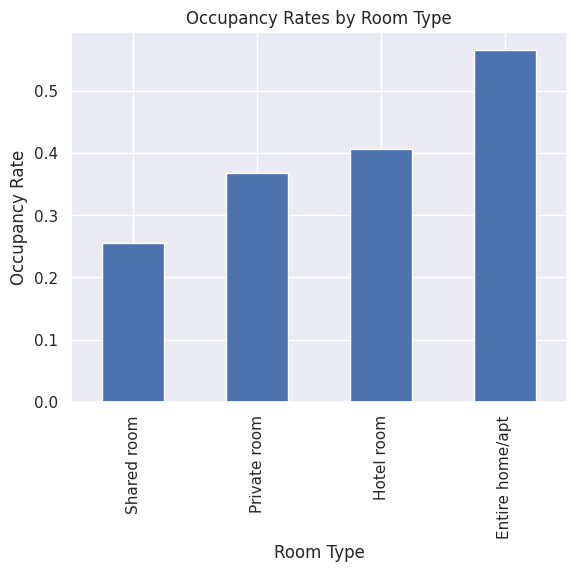

In [111]:
#Occupancy Rates by Property Type

# Calculate the occupancy rate for each listing
pandas_df["occupancy_rate"] = pandas_df["num_reviews"] / (365 / pandas_df["minimum_nights"])

# Group the data by property type and calculate the occupancy rate for each type
occupancy_rates_by_property_type = pandas_df.groupby("room_type")["occupancy_rate"].mean().sort_values()

# Create a stacked bar chart showing the occupancy rates for each property type
occupancy_rates_by_property_type.plot(kind="bar", stacked=True)
plt.xlabel("Room Type")
plt.ylabel("Occupancy Rate")
plt.title("Occupancy Rates by Room Type")
plt.show()

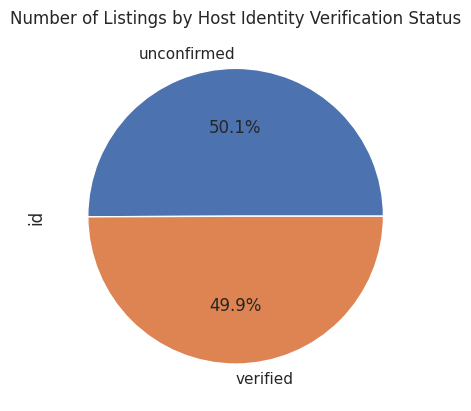

In [112]:
# Number of Listings by Host Nationality
listings_by_verified_host = pandas_df.groupby("host_identity_verified")["id"].count().sort_values(ascending=False)
listings_by_verified_host.plot(kind="pie", autopct="%1.1f%%")
plt.title("Number of Listings by Host Identity Verification Status")
plt.show()



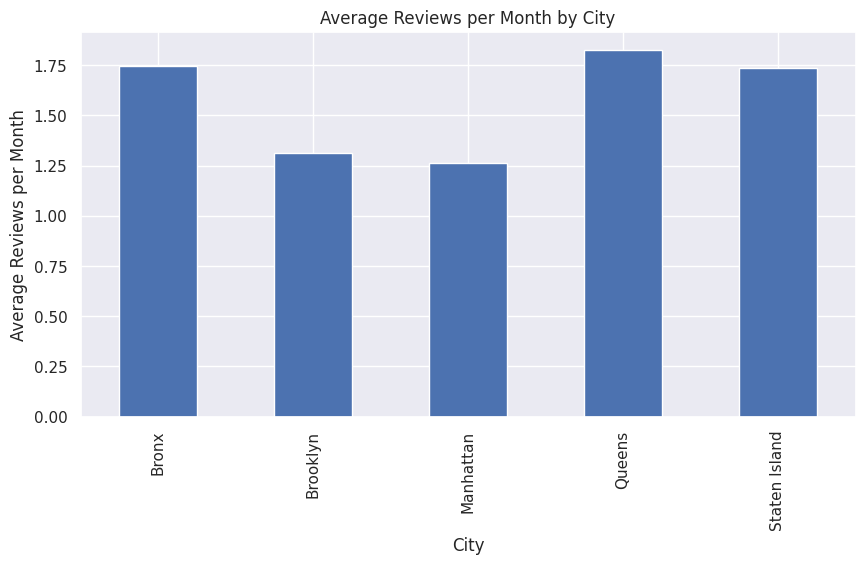

In [113]:
#Reviews per Month by City

# Group the data by city and calculate the average number of reviews per month for each city
reviews_per_month_by_city = pandas_df.groupby("neighbourhood_group")["reviews_per_month"].mean()

# Create a bar chart showing the average number of reviews per month for each city
reviews_per_month_by_city.plot(kind="bar", figsize=(10,5))
plt.title("Average Reviews per Month by City")
plt.xlabel("City")
plt.ylabel("Average Reviews per Month")
plt.show()

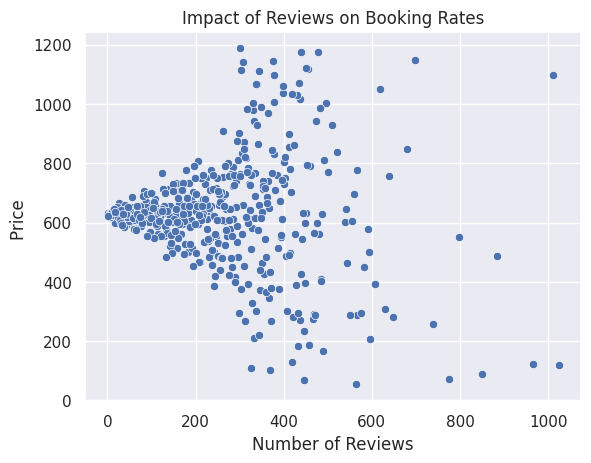

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import regexp_replace, col

# Load the data
data = df1
# Drop the columns we don't need
data = data.select(col("id"), col("price"), col("num_reviews"), col("review_rate_num"))

# Convert the price column to a float
data = data.withColumn("price", regexp_replace(col("price"), "[$,]", "").cast("float"))

# Calculate the average booking rate and review rating for each number of reviews
booking_rates = data.groupBy("num_reviews").mean().toPandas().reset_index()

# Plot the booking rate against the number of reviews
sns.scatterplot(x="num_reviews", y="avg(price)", data=booking_rates)

# Plot the review rating against the number of reviews
#sns.scatterplot(x="num_reviews", y="avg(review_rate_num)", data=booking_rates)

# Add labels to the plots
plt.title("Impact of Reviews on Booking Rates")
plt.xlabel("Number of Reviews")
plt.ylabel("Price ")

# Show the plots
plt.show()

<Axes: xlabel='neighbourhood_group'>

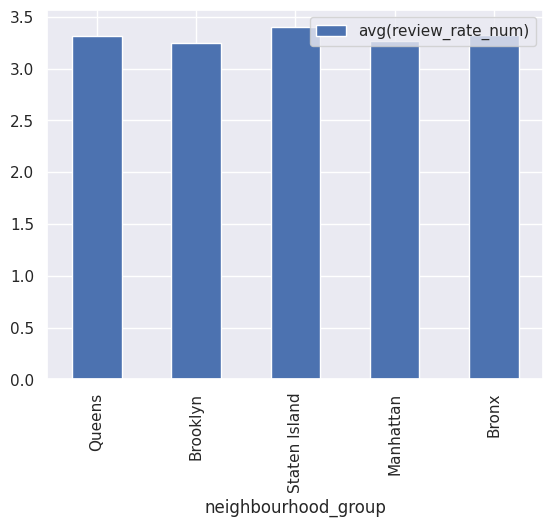

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the listings data
listings = df1

# Convert the review_scores_rating column to a float
listings = listings.withColumn("review_rate_num", listings["review_rate_num"].cast("float"))

# Group the listings by neighborhood and calculate the mean review_scores_rating
neighborhood_reviews = listings.groupby("neighbourhood_group").mean("review_rate_num")

# Plot the average review score by neighborhood
neighborhood_reviews.toPandas().plot.bar(x="neighbourhood_group", y="avg(review_rate_num)", rot=90)
#plt.xticks(rotation=90)
#plt.title("Average Review Score by Neighborhood")
#plt.xlabel("Neighborhood")
#plt.ylabel("Review Score")
#plt.show()


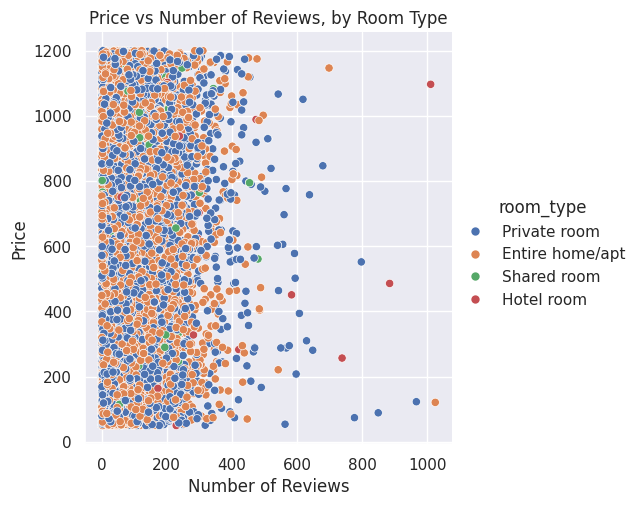

In [116]:
#finding the relation between price vs no. of reviews constrwining room type

# Filter the data to include only the relevant columns
data = df1[["room_type", "num_reviews", "price"]]

# Convert the price column to a float
#data = data.withColumn("price", regexp_replace(col("price"), "[$,]", "").cast("float"))

# Plot the data with a relplot
sns.set(style="darkgrid")
sns.relplot(x="num_reviews", y="price", hue="room_type", kind="scatter", data=data.toPandas())

# Add labels to the plot
plt.title("Price vs Number of Reviews, by Room Type")
plt.xlabel("Number of Reviews")
plt.ylabel("Price")

# Show the plot
plt.show()

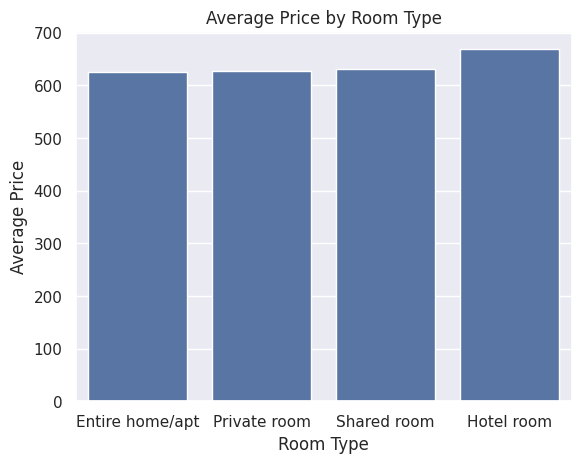

In [117]:
# Filter the data to include only the relevant columns
from pyspark.sql.functions import avg
data = df1[["room_type", "review_rate_num", "price"]]

# Convert the price column to a float
#data = data.withColumn("price", regexp_replace(col("price"), "[$,]", "").cast("float"))

# Group the data by room type and find the average price and review rate number
grouped_data = data.groupBy("room_type").agg(avg("price").alias("avg_price"), avg("review_rate_num").alias("avg_review_rate"))

# Sort the data by average price in ascending order
sorted_data = grouped_data.orderBy("avg_price")

# Plot the data with a barplot
sns.set(style="darkgrid")
sns.barplot(x="room_type", y="avg_price", data=sorted_data.toPandas())

# Add labels to the plot
plt.title("Average Price by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Average Price")

# Show the plot
plt.show()

In [118]:
from pyspark.sql.functions import avg

# Group the data by room type and compute the average price
avg_price_per_room_type = df1.groupBy("room_type").agg(avg("price"))

# Show the results
avg_price_per_room_type.show()


+---------------+-----------------+
|      room_type|       avg(price)|
+---------------+-----------------+
|    Shared room|631.6848989298454|
|     Hotel room|668.4247787610619|
|Entire home/apt|624.6113157835979|
|   Private room|627.4459114699771|
+---------------+-----------------+



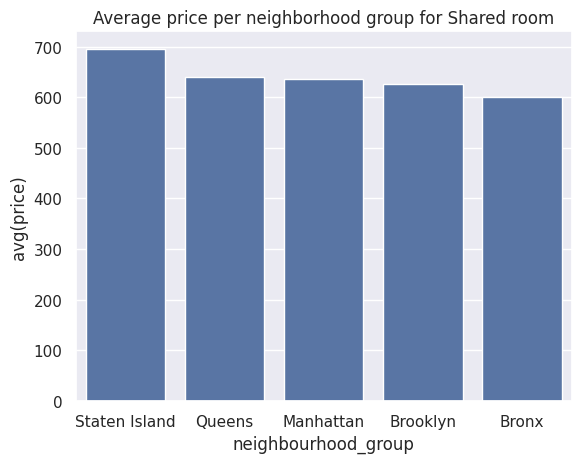

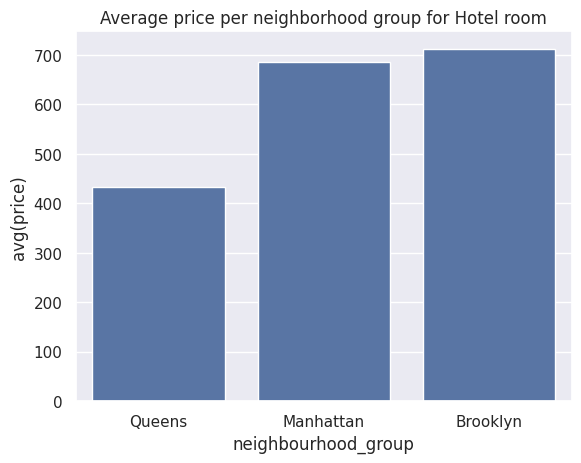

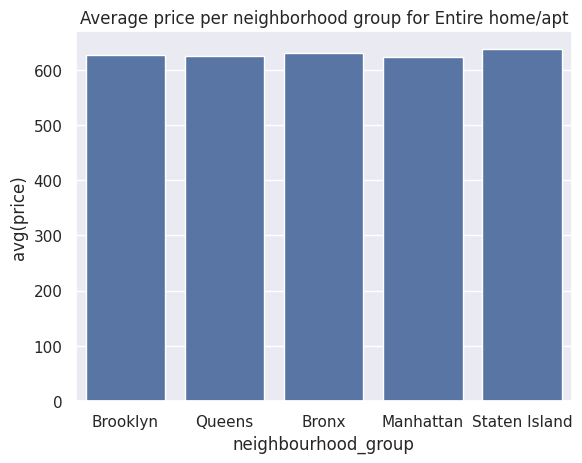

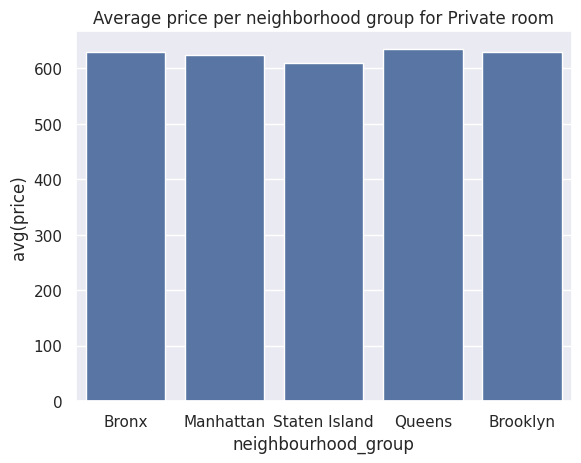

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the average price per neighborhood group for each room type
df_avg = df.groupBy("room_type", "neighbourhood_group").avg("price")

# Loop over the room types and create separate plots for each
for room_type in df_avg.select("room_type").distinct().rdd.flatMap(lambda x: x).collect():
    # Extract the data for the current room type
    data = df_avg.filter(df_avg.room_type == room_type).toPandas()

    # Plot the data
    sns.barplot(x="neighbourhood_group", y="avg(price)", data=data)
    plt.title(f"Average price per neighborhood group for {room_type}")
    plt.show()

In [120]:
from pyspark.sql.functions import avg

# Filter the data to include only private rooms
private=[]
shared=[]
entirehome=[]
hotelroom=[]
private_rooms = df.filter(df["room_type"] == "Private room")
home = df.filter(df["room_type"] == "Entire home/apt")
hotel = df.filter(df["room_type"] == "Hotel room")
shared_rooms = df.filter(df["room_type"] == "Shared room")



# Group the data by neighborhood and calculate the average price
avg_prices_p = private_rooms.groupBy("neighbourhood_group").agg(avg("price"))
avg_prices_ho = home.groupBy("neighbourhood_group").agg(avg("price"))
avg_prices_hote = hotel.groupBy("neighbourhood_group").agg(avg("price"))
avg_prices_share = shared_rooms.groupBy("neighbourhood_group").agg(avg("price"))

avg_prices_hote = avg_prices_hote.fillna(0, subset=["avg(price)"])



# Extract the data from the PySpark DataFrame and convert it to a list
avg_prices_list = avg_prices_p.rdd.map(lambda row: (row[0], row[1])).collect()
private = [tup[1] for tup in avg_prices_list]

avg_prices_list_ho = avg_prices_ho.rdd.map(lambda row: (row[0], row[1])).collect()
entirehome = [tup[1] for tup in avg_prices_list_ho]

avg_prices_list_hote = avg_prices_hote.rdd.map(lambda row: (row[0], row[1])).collect()
hotelroom = [tup[1] for tup in avg_prices_list_hote]
hotelroom.insert(2, 0)
hotelroom.append(0)



avg_prices_list_share = avg_prices_share.rdd.map(lambda row: (row[0], row[1])).collect()
shared = [tup[1] for tup in avg_prices_list_share]

print(avg_prices_list)
#print(private)
#print(entirehome)
print(hotelroom)
#print(shared)

[('Queens', 634.6521604460276), ('Brooklyn', 628.6002059233239), ('Staten Island', 610.2222222222222), ('Manhattan', 622.9463228128045), ('Bronx', 628.3952959028832)]
[433.25, 711.7142857142857, 0, 684.530612244898, 0]


In [121]:
print(private)
print(entirehome)
print(hotelroom)
print(shared)

[634.6521604460276, 628.6002059233239, 610.2222222222222, 622.9463228128045, 628.3952959028832]
[624.3087248322148, 626.1868021996333, 637.3356807511738, 622.8078259627744, 630.8024971623156]
[433.25, 711.7142857142857, 0, 684.530612244898, 0]
[640.3811188811189, 625.8977272727273, 695.25, 636.5380116959064, 600.4318181818181]


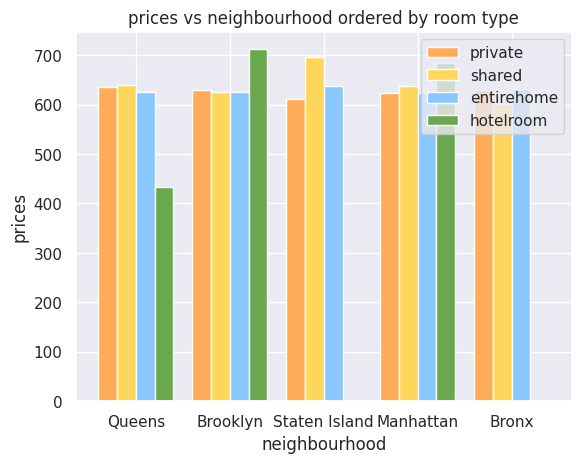

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bars

labels = ['Queens', 'Brooklyn', 'Staten Island', 'Manhattan', 'Bronx']

# Set the width of each bar
bar_width = 0.2

r1 = np.arange(len(private))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bars for men, women, boys, and girls
plt.bar(r1, private, color='#ffac58', width=bar_width, label='private')
plt.bar(r2, shared, color='#ffd65c', width=bar_width, label='shared')
plt.bar(r3, entirehome, color='#89c7ff', width=bar_width, label='entirehome')
plt.bar(r4, hotelroom, color='#6aa84f', width=bar_width, label='hotelroom')


# Add labels, title, and legend
plt.xlabel('neighbourhood')
plt.ylabel('prices')
plt.title('prices vs neighbourhood ordered by room type')
plt.xticks([r + 1.5*bar_width for r in range(len(private))], labels)
plt.legend()

# Show the plot
plt.show()

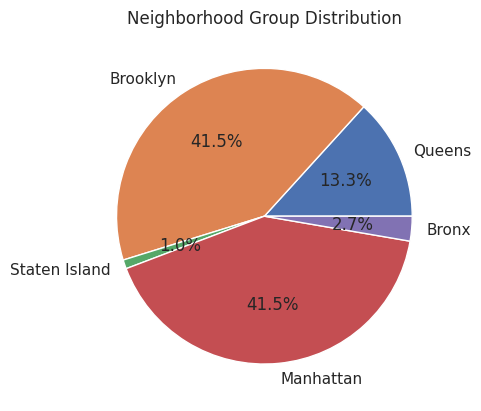

In [123]:
ng_counts = df1.groupby('neighbourhood_group').count().toPandas().reset_index()

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(ng_counts['count'], labels=ng_counts['neighbourhood_group'], autopct='%1.1f%%')

# Add a title
ax.set_title("Neighborhood Group Distribution")

# Show the plot
plt.show()

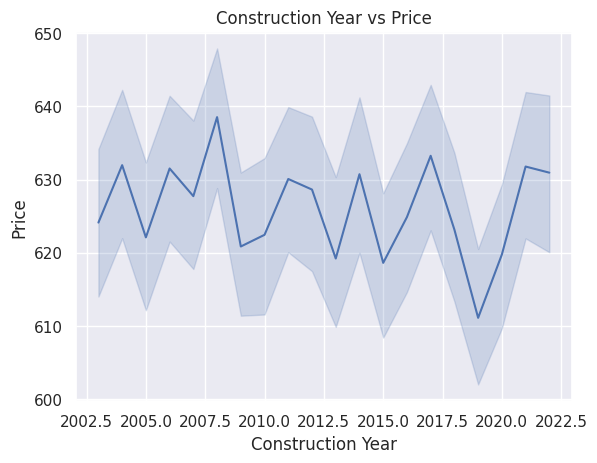

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data to include only the relevant columns
data = df1[["construction_year", "price"]]

# Convert the construction_year column to integer
data = data.withColumn("construction_year", data["construction_year"].cast("integer"))

# Sort the data by construction_year in ascending order
data = data.orderBy("construction_year")

# Plot the data with a lineplot
sns.set(style="darkgrid")
sns.lineplot(x="construction_year", y="price", data=data.toPandas())

# Add labels to the plot
plt.title("Construction Year vs Price")
plt.xlabel("Construction Year")
plt.ylabel("Price")

# Show the plot
plt.show()


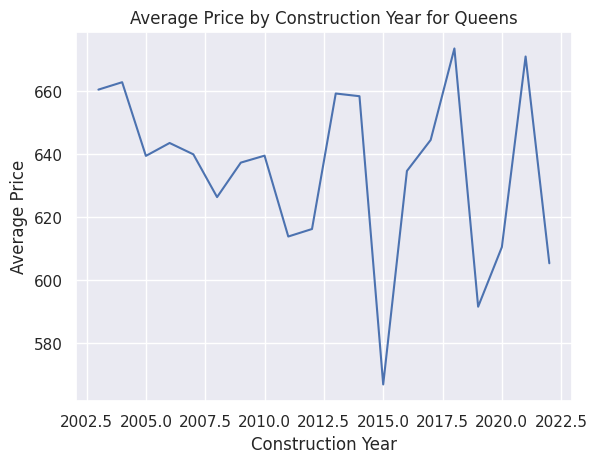

In [125]:
# Filter the data for one neighborhood
neighborhood = "Queens"
neighborhood_data = df1.filter((df1["neighbourhood_group"] == neighborhood) & (df1["room_type"] == "Private room"))

# Group the data by construction year and calculate the average price
avg_prices = neighborhood_data.groupBy("construction_year").agg(avg("price")).orderBy("construction_year")

# Extract the data from the PySpark DataFrame and convert it to a Pandas DataFrame
avg_prices_df = avg_prices.toPandas()

# Create a line plot
fig, ax = plt.subplots()
ax.plot(avg_prices_df["construction_year"], avg_prices_df["avg(price)"])

# Add labels to the plot
plt.title("Average Price by Construction Year for {}".format(neighborhood))
plt.xlabel("Construction Year")
plt.ylabel("Average Price")

# Show the plot
plt.show()


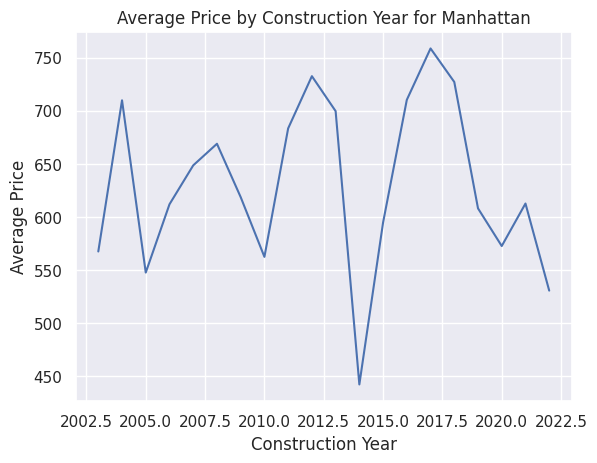

In [126]:
neighborhood = "Manhattan"
neighborhood_data = df1.filter((df1["neighbourhood_group"] == neighborhood) & (df1["room_type"] == "Shared room"))

# Group the data by construction year and calculate the average price
avg_prices = neighborhood_data.groupBy("construction_year").agg(avg("price")).orderBy("construction_year")

# Extract the data from the PySpark DataFrame and convert it to a Pandas DataFrame
avg_prices_df = avg_prices.toPandas()

# Create a line plot
fig, ax = plt.subplots()
ax.plot(avg_prices_df["construction_year"], avg_prices_df["avg(price)"])

# Add labels to the plot
plt.title("Average Price by Construction Year for {}".format(neighborhood))
plt.xlabel("Construction Year")
plt.ylabel("Average Price")

# Show the plot
plt.show()

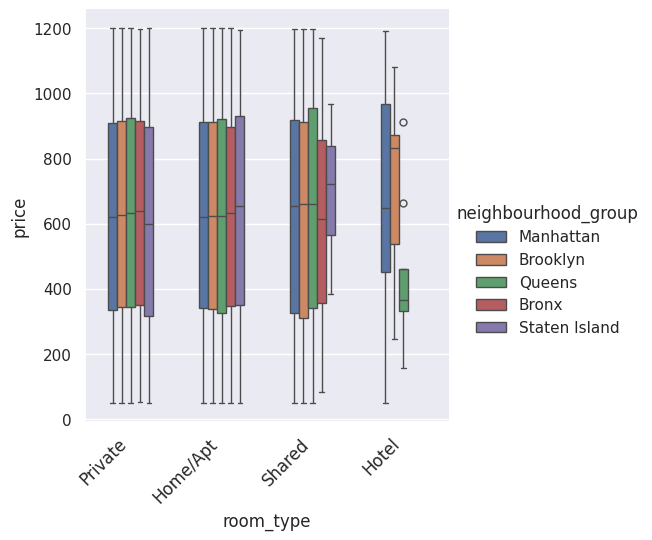

In [127]:
sns.catplot(kind="box",data=df1.toPandas(), x='room_type', y='price', hue='neighbourhood_group',width=0.5).set_xticklabels(['Private', 'Home/Apt', 'Shared','Hotel'], fontsize=12, rotation=45, ha='right');

Text(0.5, 1.0, 'Average Service Fee by Room Type')

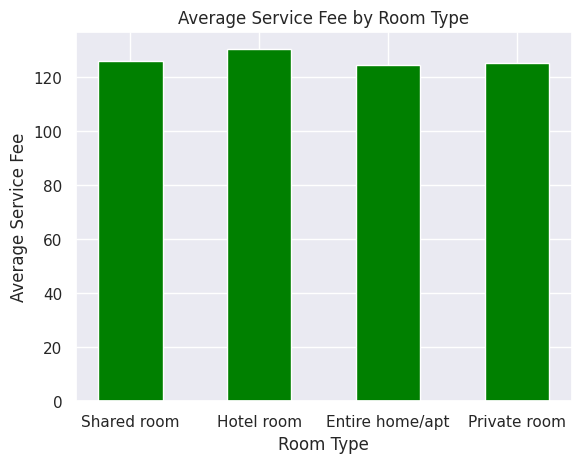

In [128]:
# Assuming your data is in a PySpark DataFrame called `df1`
import pyspark.sql.functions as F

# Group the data by room type, calculate the average service fee
data = df1.groupBy('room_type').agg(F.mean('service_fee').alias('avg_service_fee'))

# Convert the PySpark DataFrame to a pandas DataFrame
data = data.toPandas()

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(data['room_type'], data['avg_service_fee'], color= "green",width=0.5)

# Set the axis labels and title
ax.set_xlabel('Room Type')
ax.set_ylabel('Average Service Fee')
ax.set_title('Average Service Fee by Room Type')


<ipython-input-129-52da395d48c4>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x="long", y="lat", data=df1.toPandas(), shade=True, cmap='coolwarm', bw_adjust=0.3)


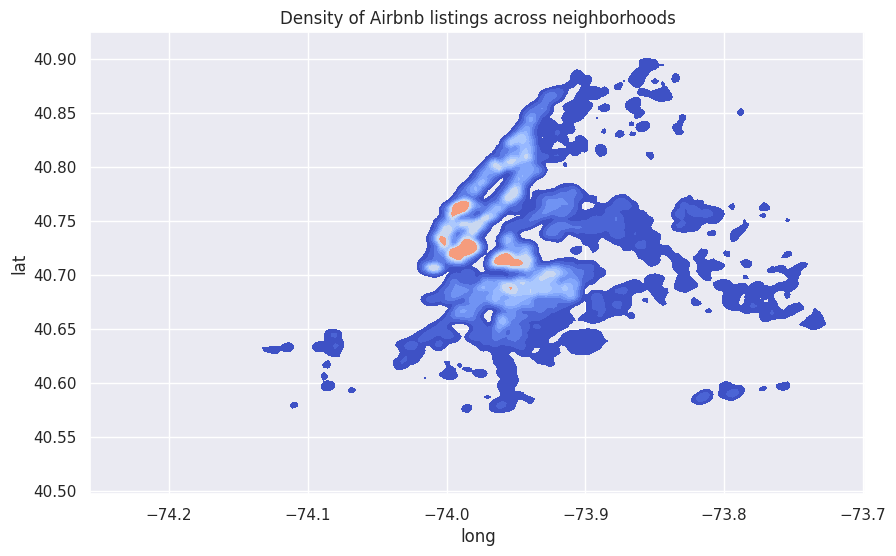

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a pandas DataFrame called `df1`
plt.figure(figsize=(10,6))
sns.kdeplot(x="long", y="lat", data=df1.toPandas(), shade=True, cmap='coolwarm', bw_adjust=0.3)
plt.title('Density of Airbnb listings across neighborhoods')
plt.show()

In [130]:
# Assuming the cleaned Spark DataFrame is called "cleaned_df"
pandas_df = df.toPandas()

# Save the Pandas DataFrame as a CSV file
pandas_df.to_csv('cleaned_airbnb_data.csv', index=False)

In [131]:
!pip install geoplot

In [132]:
import geoplot

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


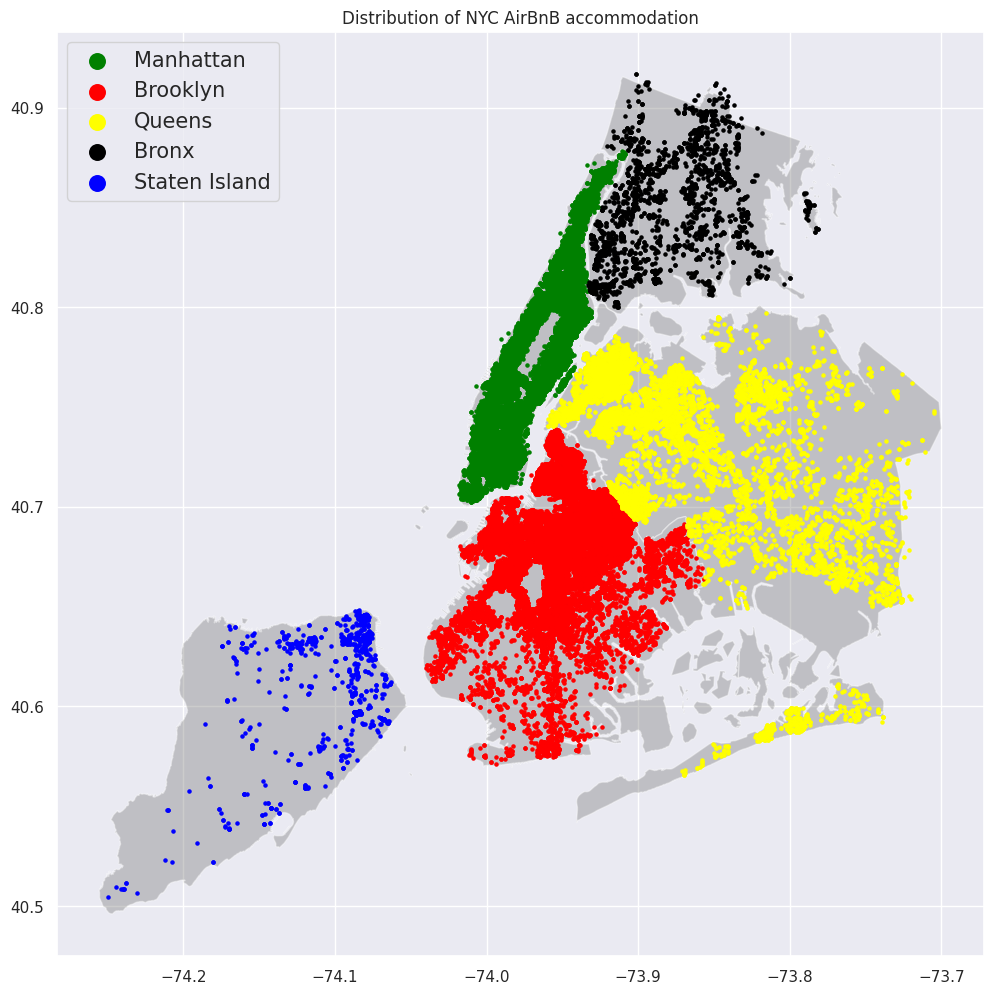

In [133]:
# import geopandas
# import matplotlib.pyplot as plt
# import geoplot
# from geopandas import GeoDataFrame
# convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()
# Plot a geo plot
crs={'init':'epsg:4326'}
boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))
geo_df=geopandas.GeoDataFrame(pandas_df,crs=crs,geometry=geopandas.points_from_xy(pandas_df["long"], pandas_df["lat"]))
# Define a function for plotting a geomap
def geodf(x, y):
  geo_df[geo_df['neighbourhood_group']== x].plot(ax=ax, markersize=5, alpha=1,color=y, label=x)
borough = {'Manhattan':'green', 'Brooklyn':'red', 'Queens':'yellow', 'Bronx':'black', 'Staten Island':'blue'}
fig,ax=plt.subplots(figsize=(12,12))
boroughs.plot(ax=ax,alpha=0.4,color="grey").set(title='Distribution of NYC AirBnB accommodation')
for x,y in borough.items():
  geodf(x,y)
plt.legend(fontsize=15, markerscale=5)

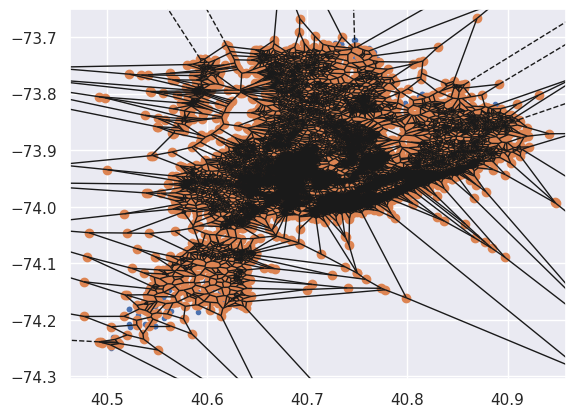

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

points = df1.select('lat', 'long').collect()
points = np.array([(float(row['lat']), float(row['long'])) for row in points])

# Compute the Voronoi diagram
vor = Voronoi(points)

# Plot the Voronoi diagram
fig = voronoi_plot_2d(vor)
plt.show()


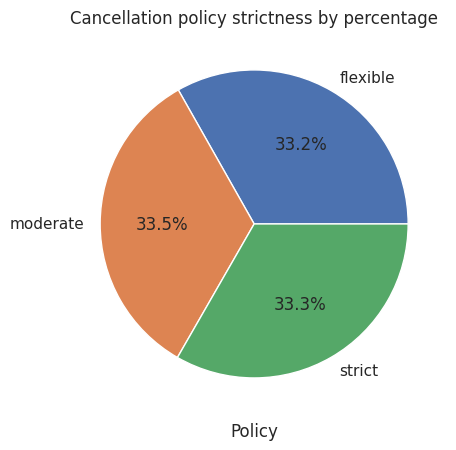

In [135]:
fig, ax = plt.subplots(figsize=(10, 5))

policy = pandas_df.groupby('cancellation_policy')['id'].count().plot(kind='pie', autopct='%1.1f%%')

ax.set(title='Cancellation policy strictness by percentage',
       xlabel='Policy',
       ylabel=None)

plt.show()

[Text(0.5, 1.0, 'Relation between Minimum of nights and number of Reviews'),
 Text(0.5, 0, 'Minimum nights'),
 Text(0, 0.5, 'Number of reviews')]

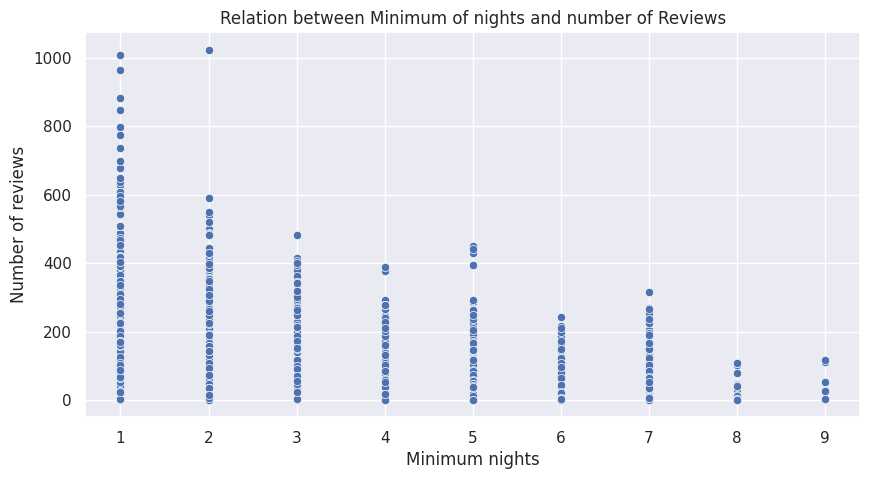

In [136]:
# Remove outliers in the 'min_nights' column

df2= df.toPandas()
Q1 = df2['minimum_nights'].quantile(0.25)
Q3 = df2['minimum_nights'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Remove outliers
df_no_ouliers = df2[(df2['minimum_nights'] > lower_bound) & (df2['minimum_nights'] < upper_bound)]
fig, ax= plt.subplots(figsize=(10, 5))
sns.scatterplot(data=df_no_ouliers, x='minimum_nights', y='num_reviews')\
                                                    .set(title='Relation between Minimum of nights and number of Reviews',
                                                         xlabel='Minimum nights',
                                                         ylabel='Number of reviews')

In [137]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- construction_year: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- service_fee: double (nullable = false)
 |-- minimum_nights: integer (nullable = false)
 |-- num_reviews: integer (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = false)
 |-- review_rate_num: double (nullable = false)
 |-- calculated_host_listings_count: double (nullable = false)
 |-- availability_365: integer (nullable = false)



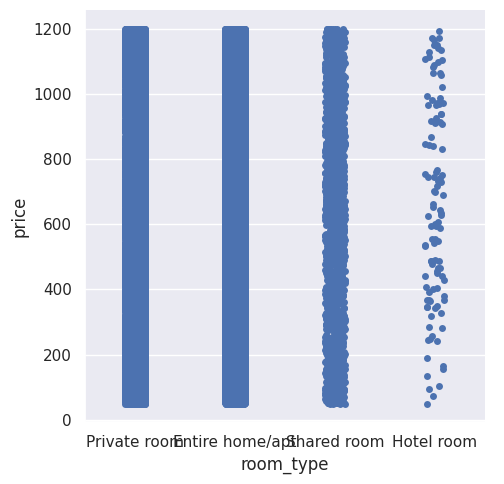

In [138]:
sns.catplot(kind="strip",data=df1.toPandas(), x='room_type', y='price');